In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import random

(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = tf.keras.datasets.imdb.load_data(num_words=4000, skip_top=10)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

#min-df --> when building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
binary_vectorizer = CountVectorizer(binary=True, min_df=100)
x_train_imdb_binary = binary_vectorizer.fit_transform(x_train_imdb)
x_test_imdb_binary = binary_vectorizer.transform(x_test_imdb)
print('Vocabulary size:', len(binary_vectorizer.vocabulary_))
      
x_train_imdb_binary = x_train_imdb_binary.toarray()
x_test_imdb_binary = x_test_imdb_binary.toarray()

# split rest of the train data into train and dev
x_train_imdb_binary, x_dev_imdb_binary, y_train_imdb, y_dev_imdb = train_test_split(x_train_imdb_binary, y_train_imdb, 
                                                  test_size=50)

Vocabulary size: 3698


In [4]:
# --------------- Creates learning curve ---------------

def custom_learning_curve(obj, x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits, train, dev, test):
  
  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  #lr = LogisticRegression()
  obj.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y, 
                                         obj.predict(curr_x)))
  
  val_accuracies.append(accuracy_score(y_val, obj.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, obj.predict(x_test)))

  for i in range(1, len(x_splits)):
    #lr = LogisticRegression()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    obj.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y, 
                                           obj.predict(curr_x)))
    
    val_accuracies.append(accuracy_score(y_val, obj.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, obj.predict(x_test)))

  if train == 1:
      plt.plot(list(range(split_size, len(x_train) + split_size, 
                          split_size)), train_accuracies, 'o-', color="b",
                 label="Training accuracy")
  if dev == 1:
      plt.plot(list(range(split_size, len(x_train) + split_size, 
                          split_size)), val_accuracies, 'o-', color="green",
               label="Validation accuracy")
  if test == 1:     
      plt.plot(list(range(split_size, len(x_train) + split_size, 
                          split_size)), test_accuracies, 'o-', color="red",
               label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

In [11]:
class LogisticRegression:
    # Initialization method
    def __init__(self, learning_rate=0.01, regularization_parameter=0.01, num_iters=100, sample_size=32):
        # Initializing the values using the hyperparameters
        self.lr = learning_rate
        self.rp = regularization_parameter
        self.num_iters = num_iters
        self.s_size = sample_size
        
    def fit(self, x, y):
        np.random.seed(0)
        # Initialize the weights randomly
        self.weights = np.random.random(x.shape[1])       
        
        for i in range(self.num_iters):
            for j in range(0, len(x), self.s_size):
                x_sample = x[j:j+self.s_size]
                y_sample = y[j:j+self.s_size]
                # Finds the predicted probabilities for each sample and stores it into possibs
                possibs = self.sigmoid_f(np.dot(x_sample, self.weights))
                # Computes the gradient
                # y_sample-possibs defines the error in the predictions, we take the transpose of x_sample in  order
                # to have the same size as the other array .
                gradient = np.dot(x_sample.T, y_sample - possibs)   
                # Updates the weights using regularization
                self.weights += self.lr * (gradient + 2 * self.rp * self.weights)        
        
    def predict(self, x):
        p_test = self.sigmoid_f(np.dot(x, self.weights))
        y_pred = (p_test > 0.5)
        return y_pred
        
    def sigmoid_f(self, x):
        return 1 / (1 + np.exp(-x))

In [12]:
# part A
# --------------- Classification Report for train data ---------------

lr = LogisticRegression()
lr.fit(x_train_imdb_binary, y_train_imdb)
y_pred = lr.predict(x_train_imdb_binary)
print(classification_report(y_train_imdb, y_pred))

C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91     12471
           1       0.91      0.91      0.91     12479

    accuracy                           0.91     24950
   macro avg       0.91      0.91      0.91     24950
weighted avg       0.91      0.91      0.91     24950



In [13]:
# --------------- Classification Report for test data ---------------

lr = LogisticRegression()
lr.fit(x_train_imdb_binary, y_train_imdb)
y_pred = lr.predict(x_test_imdb_binary)
print(classification_report(y_test_imdb, y_pred))

C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



(4990, 3698)
(4990,)
(9980, 3698)
(9980,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(14970, 3698)
(14970,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(19960, 3698)
(19960,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(24950, 3698)
(24950,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


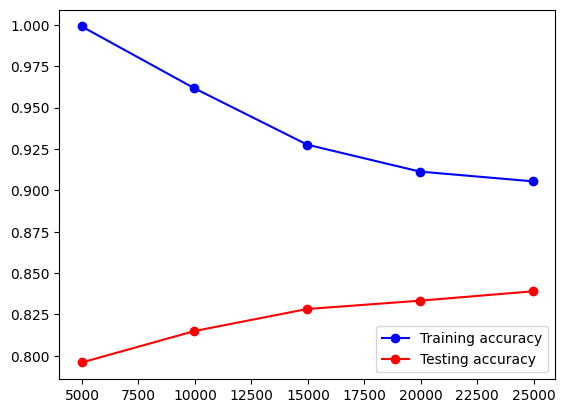

In [14]:
# Learning curve for train and test data

custom_learning_curve(lr, x_train=x_train_imdb_binary, y_train=y_train_imdb,
                      x_val=x_dev_imdb_binary, y_val=y_dev_imdb, x_test=x_test_imdb_binary,
                      y_test=y_test_imdb, n_splits=5, train=1, dev=0, test=1)

(4990, 3698)
(4990,)
(9980, 3698)
(9980,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(14970, 3698)
(14970,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(19960, 3698)
(19960,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(24950, 3698)
(24950,)


C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\giorg\AppData\Local\Temp\ipykernel_19332\2295022803.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


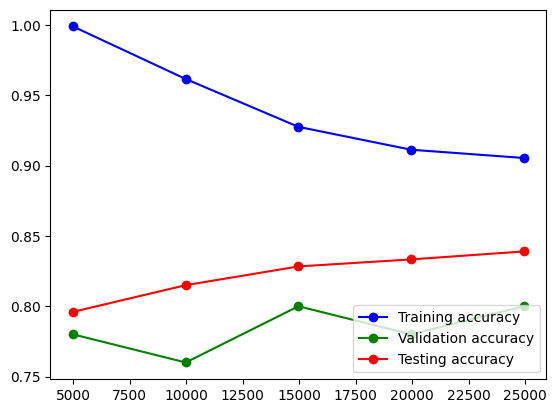

In [15]:
# Learning curve for all data
custom_learning_curve(lr, x_train=x_train_imdb_binary, y_train=y_train_imdb,
                      x_val=x_dev_imdb_binary, y_val=y_dev_imdb, x_test=x_test_imdb_binary,
                      y_test=y_test_imdb, n_splits=5, train=1, dev=1, test=1)

c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--------------- Train Data ---------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     12473
           1       0.93      0.94      0.94     12477

    accuracy                           0.94     24950
   macro avg       0.94      0.94      0.94     24950
weighted avg       0.94      0.94      0.94     24950

--------------- Test Data ---------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

(4990, 3698)
(4990,)


c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(9980, 3698)
(9980,)


c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(14970, 3698)
(14970,)


c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(19960, 3698)
(19960,)


c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(24950, 3698)
(24950,)


c:\users\giorg\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


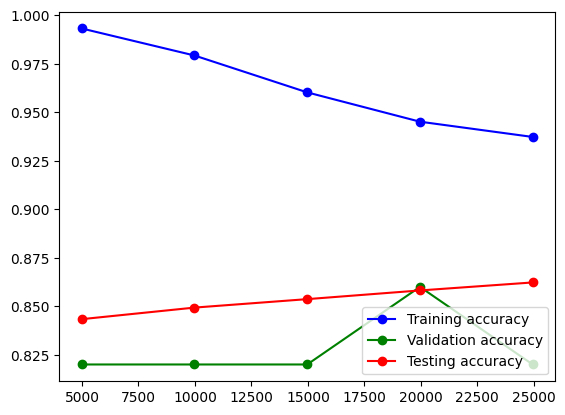

In [8]:
# part B
from sklearn.linear_model import LogisticRegression

#Algorithm to use in the optimization problem.
#Each solver tries to find the parameter weights that minimize a cost function
log = LogisticRegression(solver='saga')
log.fit(x_train_imdb_binary, y_train_imdb)
print("--------------- Train Data ---------------")
print(metrics.classification_report(y_train_imdb, log.predict(x_train_imdb_binary)))
print("--------------- Test Data ---------------")
print(metrics.classification_report(y_test_imdb, log.predict(x_test_imdb_binary)))

custom_learning_curve(log, x_train=x_train_imdb_binary, y_train=y_train_imdb,
                      x_val=x_dev_imdb_binary, y_val=y_dev_imdb, x_test=x_test_imdb_binary,
                      y_test=y_test_imdb, n_splits=5, train=1, dev=1, test=1)